# Feature Engineering
- One-hot Encoding

- feature selection    
   1) stepwise feature     
   2) RFECV     
   
- feature extraction 

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import time
from datetime import timedelta
import math
import pickle
import copy
import seaborn as sns
from numpy import sqrt 

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False 

pd.options.display.float_format = '{:.5f}'.format

import warnings 
warnings.filterwarnings(action='ignore')
pd.options.display.float_format = '{:.5f}'.format

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
import random
from keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
df = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/FactoryHack2022/Final/data/Final_Data.xlsx')

## 1. One-hot Encoding     
- Categorical Variable인 Lamp No. 컬럼의  One-hot Encoding 수행 

In [4]:
def One_hot_Encoding(data, categorical_col_name ,items):   
    encoder = LabelEncoder()
    encoder.fit(items)
    labels = encoder.transform(items)
    labels = labels.reshape(-1,1)

    oh_encoder = OneHotEncoder()
    oh_encoder.fit(labels)
    oh_labels = oh_encoder.transform(labels)
    
    return pd.get_dummies(data[categorical_col_name])

In [5]:
df_lamp = df.copy(deep=True)
df_lamp['Lamp Ver. No.'] = df_lamp['Lamp Ver. No.'].apply(lambda x: "lamp_ver_"+str(x))

lamp_version = list(df_lamp['Lamp Ver. No.'].unique())
lamp_version_OHE = One_hot_Encoding(df_lamp, 'Lamp Ver. No.' ,lamp_version)
df_lamp_new = pd.concat([df_lamp, lamp_version_OHE], axis=1).reset_index(drop=True)

In [6]:
process = list(df_lamp_new.loc[:, '1-수소공급량':'강도'].columns)
lamp_list = list(df_lamp_new.loc[:, "lamp_ver_21":"lamp_ver_69"].columns)
y_list = ['y_cum_time', 'event']

df_lamp_new = df_lamp_new[['Lot No.']+process+lamp_list+y_list]

In [7]:
df_lamp_new.head()

,Lot No.,1-수소공급량,2-수소공급량,1-산소공급량,2-산소공급량,1-버너회전수,2-버너회전수,1-버너속도,2-버너속도,1-핀치횟수,2-핀치횟수,핀치두께-상,핀치두께-중,핀치두께-하,핀치두께2-상,핀치두께2-중,핀치두께2-하,전극간격,채널,전압(1차),전류(1차),역률(1차),전력(1차),온도(1차),전압(2차),전류(2차),역률(2차),전력(2차),온도(2차),강도,lamp_ver_21,lamp_ver_22,lamp_ver_24,lamp_ver_25,lamp_ver_26,lamp_ver_27,lamp_ver_28,lamp_ver_33,lamp_ver_34,lamp_ver_35,lamp_ver_36,lamp_ver_37,lamp_ver_39,lamp_ver_40,lamp_ver_41,lamp_ver_42,lamp_ver_43,lamp_ver_44,lamp_ver_45,lamp_ver_46,lamp_ver_47,lamp_ver_48,lamp_ver_49,lamp_ver_50,lamp_ver_52,lamp_ver_53,lamp_ver_54,lamp_ver_57,lamp_ver_58,lamp_ver_59,lamp_ver_60,lamp_ver_61,lamp_ver_62,lamp_ver_63,lamp_ver_64,lamp_ver_65,lamp_ver_66,lamp_ver_67,lamp_ver_68,lamp_ver_69,y_cum_time,event
0,GV4KI7P051,-0.66667,-0.50000,0.85000,0.66667,1.40000,1.00000,0.50000,0.80000,0.52479,0.52483,0.86667,0.11111,0.57143,0.83333,0.31579,0.58824,0.46535,-0.66667,-2.35744,1.46377,1.26087,0.40000,-0.90000,-0.12623,-0.93333,1.09091,-0.00028,0.93651,1.90476,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,858.57000,0
1,GV4KI7P052,-0.66667,-0.50000,0.85000,0.66667,1.40000,1.00000,0.50000,0.80000,0.52523,0.52528,0.93333,0.33333,0.71429,0.16667,0.00000,0.17647,0.11881,-0.33333,-2.35744,1.46377,1.26087,0.40000,-0.90000,1.22781,-1.66667,0.90909,0.00000,0.93651,2.46032,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,858.57000,0
2,GV4KI7Q099,-0.66667,-0.50000,0.85000,0.66667,1.40000,1.00000,0.50000,0.80000,0.58553,0.58568,1.26667,0.66667,0.85714,0.16667,0.26316,-0.05882,-2.33663,-0.66667,-0.71694,0.75362,1.08696,0.80000,-0.90000,0.55621,-0.60000,0.81818,0.00005,1.04762,2.14286,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,858.57000,0
3,GV4KI7Q100,-0.66667,-0.50000,0.85000,0.66667,1.40000,1.00000,0.50000,0.80000,0.58598,0.58613,1.33333,0.50000,0.85714,0.05556,0.26316,-0.05882,0.29703,-0.33333,-0.71694,0.75362,1.08696,0.80000,-0.90000,0.92505,-1.33333,0.50000,-0.00005,1.04762,2.38095,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,858.57000,0
4,GV4KI8A058,-0.66667,-0.50000,0.85000,0.66667,1.40000,1.00000,0.50000,0.80000,-0.62796,-0.62908,1.20000,0.88889,1.07143,0.66667,1.00000,0.64706,-0.33663,0.66667,-1.71074,0.72464,0.56522,-0.20000,-0.80000,-0.01479,-0.26667,0.81818,-0.00014,0.90476,2.26984,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,838.28000,0


## 2. Feature Selection using Stepwise 

In [8]:
import statsmodels.api as sm

def StepWise(X_sf, y_sf): # Stepwise(X,y)

    variables = X_sf.columns.tolist() 

    y = y_sf.copy(deep=True)
    selected_variables = [] 
    sl_enter = 0.05
    sl_remove = 0.05

    sv_per_step = []
    adjusted_r_squared = [] 
    steps = [] 
    step = 0
    while len(variables) > 0:
        remainder = list(set(variables) - set(selected_variables))
        pval = pd.Series(index=remainder) 
        for col in remainder: 
            X = X_sf[selected_variables+[col]]
            X = sm.add_constant(X)
            model = sm.OLS(y.astype(float), X.astype(float)).fit()
            pval[col] = model.pvalues[col]

        min_pval = pval.min()
        if min_pval < sl_enter:
            selected_variables.append(pval.idxmin())
            while len(selected_variables) > 0:
                selected_X = X_sf[selected_variables]
                selected_X = sm.add_constant(selected_X)
                selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] 
                max_pval = selected_pval.max()
                if max_pval >= sl_remove: 
                    remove_variable = selected_pval.idxmax()
                    selected_variables.remove(remove_variable)
                else:
                    break

            step += 1
            steps.append(step)
            adj_r_squared = sm.OLS(y,sm.add_constant(X_sf[selected_variables])).fit().rsquared_adj
            adjusted_r_squared.append(adj_r_squared)
            sv_per_step.append(selected_variables.copy())
        else:
            break
            
    return selected_variables

In [9]:
X = df_lamp_new.loc[:, '1-수소공급량':'lamp_ver_69']
y = df_lamp_new['y_cum_time']

In [10]:
# Stepwise 
selected_stepwise = StepWise(X,y)
selected_process_stepwise =  StepWise(X.loc[:,"1-수소공급량":'강도'],y)
selected_lamp_version_stepwise =  StepWise(X.loc[:, "lamp_ver_21":"lamp_ver_69"],y)

- Stepwise feature selection 1: 전체 feature들을 대상으로 수행 

In [11]:
stepwise_full = df_lamp_new[['Lot No.']+selected_stepwise+ y_list]

- Stepwise feature selection 2: 공정 process 관련, lamp version 관련 변수들을 각각 선정함 

In [12]:
stepwise_seperate = df_lamp_new[['Lot No.']+selected_process_stepwise+selected_lamp_version_stepwise+ y_list]

## 3. Feature Selection using RFECV(Recursive Feature Elimination with Cross Validation)

In [13]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR

def RFECV_function(X,y):
    
    estimator = SVR(kernel="linear")
    selector = RFECV(estimator, step=1, cv=5, min_features_to_select=1)
    selector = selector.fit(X, y)
    
    condition = selector.support_
    
    return list(X.loc[:, condition].columns)

In [14]:
# RFECV 
selected_rfecv = RFECV_function(X,y)
selected_process_rfecv = RFECV_function(X.loc[:,"1-수소공급량":'강도'],y)
selected_lamp_version_rfecv = RFECV_function(X.loc[:, "lamp_ver_21":"lamp_ver_69"],y)

- RFECV feature selection 1: 전체 feature들을 대상으로 수행 

In [15]:
rfecv_full = df_lamp_new[['Lot No.']+selected_rfecv+ y_list]

- RFECV feature selection 2: 공정 process 관련, lamp version 관련 변수들을 각각 선정함 

In [16]:
rfecv_seperate = df_lamp_new[['Lot No.']+selected_process_rfecv+selected_lamp_version_rfecv+ y_list]

## 4. Feature Selection using Correlation 

##### 변수 간 Correlation 확인     
1) 공정 관련 변수 간의 correlation 확인     
2) 물성 검사 관련 변수 간의 correlation 확인     

In [17]:
process = [ '1-수소공급량', '2-수소공급량', '1-산소공급량', '2-산소공급량', '1-버너회전수', '2-버너회전수',
       '1-버너속도', '2-버너속도', '1-핀치횟수', '2-핀치횟수', '핀치두께-상', '핀치두께-중', '핀치두께-하',
       '핀치두께2-상', '핀치두께2-중', '핀치두께2-하', '전극간격']

light_test = ['채널', '전압(1차)', '전류(1차)', '역률(1차)', '전력(1차)', '온도(1차)', '전압(2차)', '전류(2차)', '역률(2차)', '전력(2차)', '온도(2차)', '강도']
y = ['y_cum_time']

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


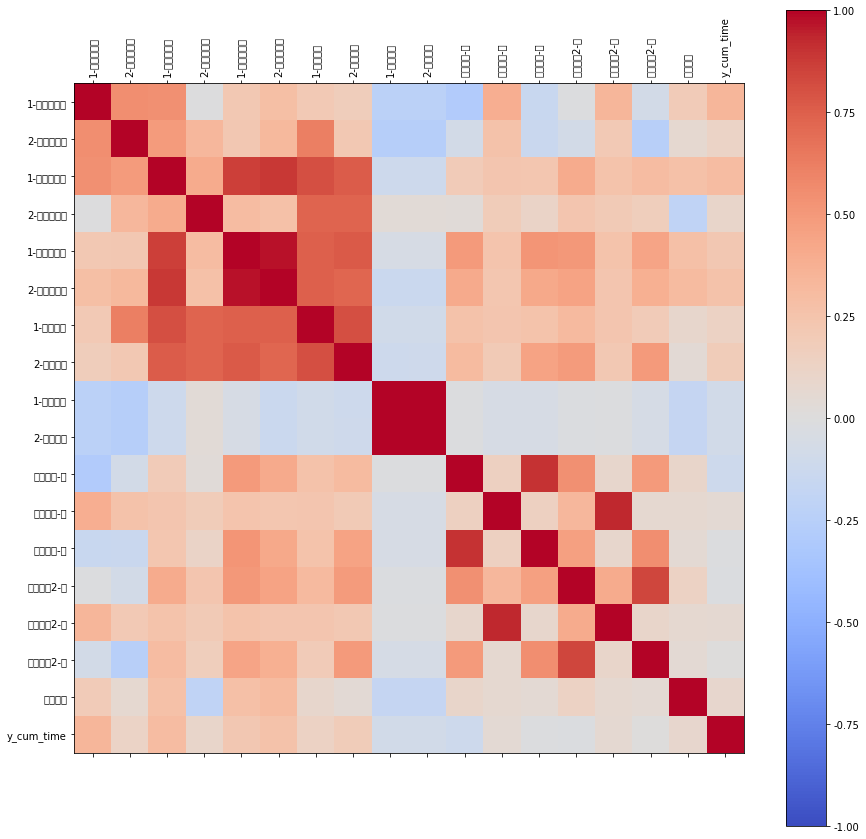

In [18]:
df_corr = df_lamp_new[process+y].corr(method='pearson', min_periods=1)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
cax = ax.matshow(df_corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_corr.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_corr.columns)
ax.set_yticklabels(df_corr.columns)
plt.show()

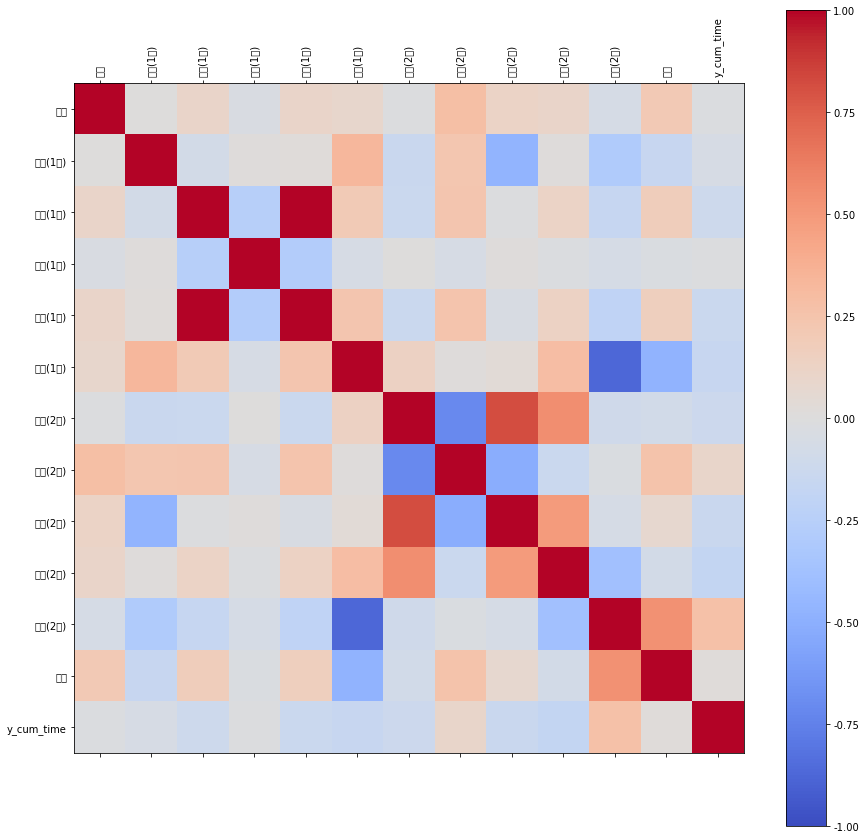

In [19]:
df_corr_2 = df_lamp_new[light_test+y].corr(method='pearson', min_periods=1)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
cax = ax.matshow(df_corr_2, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_corr_2.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_corr_2.columns)
ax.set_yticklabels(df_corr_2.columns)
plt.show()

- 상관관계가 0.75 이상인 변수들 중, 한 가지만 선택함
- correlation의 유사도가 큰 것들 중 rule-based로 한 가지만 선택

In [20]:
df_corr[abs(round(df_corr,2)) >= 0.75]

,1-수소공급량,2-수소공급량,1-산소공급량,2-산소공급량,1-버너회전수,2-버너회전수,1-버너속도,2-버너속도,1-핀치횟수,2-핀치횟수,핀치두께-상,핀치두께-중,핀치두께-하,핀치두께2-상,핀치두께2-중,핀치두께2-하,전극간격,y_cum_time
1-수소공급량,1.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2-수소공급량,nan,1.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1-산소공급량,nan,nan,1.00000,nan,0.86530,0.88859,0.80882,0.75995,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2-산소공급량,nan,nan,nan,1.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1-버너회전수,nan,nan,0.86530,nan,1.00000,0.96980,0.74652,0.76701,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2-버너회전수,nan,nan,0.88859,nan,0.96980,1.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1-버너속도,nan,nan,0.80882,nan,0.74652,nan,1.00000,0.81220,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2-버너속도,nan,nan,0.75995,nan,0.76701,nan,0.81220,1.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1-핀치횟수,nan,nan,nan,nan,nan,nan,nan,nan,1.00000,1.00000,nan,nan,nan,nan,nan,nan,nan,nan
2-핀치횟수,nan,nan,nan,nan,nan,nan,nan,nan,1.00000,1.00000,nan,nan,nan,nan,nan,nan,nan,nan


In [21]:
df_corr_2[abs(round(df_corr_2,2)) >= 0.75]

,채널,전압(1차),전류(1차),역률(1차),전력(1차),온도(1차),전압(2차),전류(2차),역률(2차),전력(2차),온도(2차),강도,y_cum_time
채널,1.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
전압(1차),nan,1.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
전류(1차),nan,nan,1.00000,nan,0.99395,nan,nan,nan,nan,nan,nan,nan,nan
역률(1차),nan,nan,nan,1.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan
전력(1차),nan,nan,0.99395,nan,1.00000,nan,nan,nan,nan,nan,nan,nan,nan
온도(1차),nan,nan,nan,nan,nan,1.00000,nan,nan,nan,nan,-0.86763,nan,nan
전압(2차),nan,nan,nan,nan,nan,nan,1.00000,nan,0.81858,nan,nan,nan,nan
전류(2차),nan,nan,nan,nan,nan,nan,nan,1.00000,nan,nan,nan,nan,nan
역률(2차),nan,nan,nan,nan,nan,nan,0.81858,nan,1.00000,nan,nan,nan,nan
전력(2차),nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00000,nan,nan,nan


In [22]:
process_3 = [x for x in process if x not in ['2-버너회전수','1-산소공급량','1-버너속도','2-버너속도', '핀치두께-하', '핀치두께2-하', '핀치두께2-중', '2-핀치횟수']]
light_test_3 = [x for x in light_test if x not in ['전류(1차)','온도(2차)', '전압(2차)']]

In [23]:
df_selected_by_corr = df_lamp_new[['Lot No.']+process_3+light_test_3+list(df_lamp_new.loc[:, "lamp_ver_21":'lamp_ver_69'].columns)]
df_selected_by_corr['y_cum_time'] = df_lamp_new['y_cum_time']
df_selected_by_corr['event'] = df_lamp_new['event']

## 5. Feature Extraction using Autoencoder 

In [28]:
def AutoEncoder(X, y, feature_nums): 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42)
   
    # This is the dimension of the original space
    input_dim = X_train.shape[1]

    # This is the dimension of the latent space (encoding space)
    latent_dim = feature_nums

    encoder = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(latent_dim, activation='relu')
    ])

    decoder = Sequential([
        Dense(64, activation='relu', input_shape=(latent_dim,)),
        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dense(input_dim, activation=None)
    ])

    model = Model(inputs=encoder.input, outputs=decoder(encoder.output))
    model.compile(loss='mse', optimizer='adam')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)   
    history = model.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=1, validation_data=(X_val,y_val),callbacks=[early_stopping])
    
    plt.plot(history.history["loss"])
    plt.title("Loss vs. Epoch")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.grid(True)
    
    df_encoded_x = pd.DataFrame(encoder.predict(X)).reset_index(drop=True)
    df_encoded_x.columns = ["feature_"+ str(i) for i in list(df_encoded_x.columns)]
    df_encoded_y = pd.DataFrame({"y_cum_time":y}).reset_index(drop=True)
    df_encoded = pd.concat([df_encoded_x, df_encoded_y], axis=1)
    
    return df_encoded

Epoch 1/1000
6/6 [==============================] - 1s 57ms/step - loss: 1120596.1250 - val_loss: 2018092.3750
Epoch 2/1000
6/6 [==============================] - 0s 7ms/step - loss: 1119948.2500 - val_loss: 2015987.6250
Epoch 3/1000
6/6 [==============================] - 0s 7ms/step - loss: 1116298.8750 - val_loss: 2008677.6250
Epoch 4/1000
6/6 [==============================] - 0s 7ms/step - loss: 1110945.1250 - val_loss: 1985109.6250
Epoch 5/1000
6/6 [==============================] - 0s 9ms/step - loss: 1102909.3750 - val_loss: 1949864.8750
Epoch 6/1000
6/6 [==============================] - 0s 7ms/step - loss: 1084435.7500 - val_loss: 1900962.0000
Epoch 7/1000
6/6 [==============================] - 0s 7ms/step - loss: 1045343.6875 - val_loss: 1747532.5000
Epoch 8/1000
6/6 [==============================] - 0s 8ms/step - loss: 955625.8125 - val_loss: 1446950.5000
Epoch 9/1000
6/6 [==============================] - 0s 8ms/step - loss: 893685.7500 - val_loss: 1326028.8750
Epoch 10/10

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


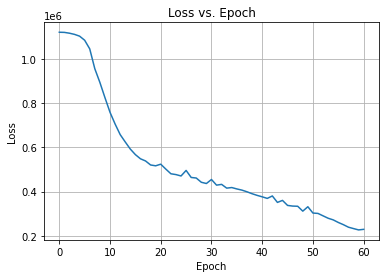

In [33]:
df_encoded = AutoEncoder(X, df_lamp_new['y_cum_time'], 10)
df_encoded['event'] = list(df_lamp_new['event'])
df_encoded['Lot No.'] = list(df_lamp_new['Lot No.'])

In [34]:
df_encoded = df_encoded[['Lot No.','feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4','feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'y_cum_time', 'event']]

In [35]:
df_encoded

,Lot No.,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,y_cum_time,event
0,GV4KI7P051,6.32674,5.47642,11.20787,3.64505,0.00000,1.40362,0.00000,7.91892,14.17054,8.08622,858.57000,0
1,GV4KI7P052,7.36939,5.88349,13.55249,4.57881,0.00000,2.25084,0.00000,9.18386,16.36756,9.45231,858.57000,0
2,GV4KI7Q099,7.73484,5.79000,14.55410,5.11498,0.00000,2.92108,0.00000,9.36149,16.87644,9.29255,858.57000,0
3,GV4KI7Q100,7.19846,5.07953,13.90479,4.91376,0.00000,3.04336,0.00000,9.17978,16.48949,9.72519,858.57000,0
4,GV4KI8A058,5.57699,5.77659,11.45878,3.89375,0.64079,1.58556,0.00000,7.72583,15.12208,7.21622,838.28000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,GN4KL3V145,5.94941,5.78133,12.76984,5.36417,0.31687,2.31082,0.00000,4.47718,16.50555,10.75763,956.02000,1
296,GN4KL3V156,5.42859,5.84367,11.72721,4.95585,0.28475,1.77759,0.00000,3.75230,15.32447,10.09988,946.02000,1
297,GN4KL3V157,6.04551,6.57441,12.90890,5.32291,0.39206,1.90296,0.00000,4.27688,16.90782,10.80736,520.35000,1
298,GN4KL3V153,2.41438,5.27630,5.63345,3.21625,1.39490,0.00000,0.00000,1.46228,9.61823,6.88324,234.13000,1


### Feature Engineering 완료된 데이터셋 저장

In [ ]:
# 기존 + One hot encoding 
#df_lamp_new.to_excel("Dataset/1.One Hot Encoding.xlsx", index=False)

# Stepwise Feature selection 
#stepwise_full.to_excel("Dataset/2.Stepwise Full.xlsx", index=False)
#stepwise_seperate.to_excel("Dataset/3.Stepwise Seperate.xlsx", index=False)

# RFECV Feature Selection 
#rfecv_full.to_excel("Dataset/4.RFECV Full.xlsx", index=False)
#rfecv_seperate.to_excel("Dataset/5.RFECV Seperate.xlsx", index=False)

# Correlation based Feature Selection 
#df_selected_by_corr.to_excel("Dataset/6.Correlation.xlsx", index=False)

# Autoencoder Feature Extraction
#df_encoded.to_excel("Dataset/7.Autoencoder.xlsx", index=False)